In [1]:
# -*- coding: utf-8 -*-
"""
수원시 한식(타겟) + 배달(보조피처) 데이터로 3가지 모델(RF/XGB/Deep-MLP) 학습
- 시간대(HOUR)별로 모델 분리 학습 (1~10)
- 결측치 방어 + 범주형 원핫 + 수치형 스케일링
- 저장: ./models/{HOUR}/model_*.joblib

필요 패키지:
pip install pandas numpy scikit-learn joblib
(선택) xgboost 설치하면 XGBRegressor 사용, 없으면 HistGradientBoostingRegressor로 대체
pip install xgboost
"""

import os
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost가 있으면 사용, 없으면 대체 모델 사용
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingRegressor
    HAS_XGB = False

warnings.filterwarnings("ignore")


# -----------------------------
# 1) 데이터 로드
# -----------------------------
HANSIK_PATH = "C:/data/suwon_data/수원시 한식 데이터백업.csv"
DELIV_PATH  = "C:/data/suwon_data/수원시 배달 데이터백업.csv"

hansik = pd.read_csv(HANSIK_PATH)
deliv  = pd.read_csv(DELIV_PATH)

# 기본 컬럼 체크(둘 다 동일한 컬럼 구조일 수 있음)
required = {"TA_YMD", "DONG", "HOUR", "DAY", "UNIT"}
missing = required - set(hansik.columns)
if missing:
    raise ValueError(f"[한식 데이터] 필수 컬럼이 없습니다: {missing}")

missing2 = {"TA_YMD", "DONG", "HOUR", "DAY"} - set(deliv.columns)
if missing2:
    raise ValueError(f"[배달 데이터] 필수 컬럼이 없습니다: {missing2}")


# -----------------------------
# 2) 배달 데이터 피처화(DELIV_ prefix)
#    - TA_YMD+DONG+HOUR(+DAY) 기준 merge
# -----------------------------
merge_keys = ["TA_YMD", "DONG", "HOUR", "DAY"]

# 배달 데이터에서 merge 키 제외한 컬럼에 prefix 부여
deliv_feat = deliv.copy()
for c in deliv_feat.columns:
    if c not in merge_keys:
        deliv_feat.rename(columns={c: f"DELIV_{c}"}, inplace=True)

# LEFT JOIN: 한식 레코드 기준으로 배달피처 붙이기
df = hansik.merge(deliv_feat, on=merge_keys, how="left")


# -----------------------------
# 3) 날짜 파생변수 생성
# -----------------------------
# TA_YMD: 20230101 형태라고 가정
df["TA_YMD"] = df["TA_YMD"].astype(str)
df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

df["YEAR"] = df["DATE"].dt.year
df["MONTH"] = df["DATE"].dt.month
df["DAY_OF_MONTH"] = df["DATE"].dt.day
df["WEEKOFYEAR"] = df["DATE"].dt.isocalendar().week.astype(int)

# (옵션) 타겟 로그변환을 원하면 True
USE_LOG_TARGET = False

# 타겟
y = df["UNIT"].copy()
if USE_LOG_TARGET:
    y = np.log1p(y)


# -----------------------------
# 4) 피처 선택
#    - 누수(leakage) 가능성이 큰 컬럼(예: 한식 AMT, CNT)은 원하면 제외 가능
# -----------------------------
# 한식 데이터의 AMT/CNT는 UNIT과 매우 강하게 연동될 가능성이 높아 "예측 목적"에 따라 제외 권장.
# 여기서는 기본값으로 제외(날짜/날씨/배달환경 중심)
DROP_COLS = [
    "UNIT", "DATE",  # 타겟/원본 datetime
    "AMT", "CNT"     # (한식) 매출/건수 -> 누수 위험. 필요하면 주석 처리해서 포함 가능
]

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")


# -----------------------------
# 5) 전처리 파이프라인
# -----------------------------
# 범주형/수치형 자동 분리
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)


# -----------------------------
# 6) 모델 정의 (RF / XGB(or 대체) / Deep-MLP)
# -----------------------------
def build_models(random_state=42):
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=random_state
    )

    if HAS_XGB:
        xgb = XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=random_state,
            tree_method="hist"
        )
    else:
        # xgboost 없으면 대체(빠르고 성능 괜찮음)
        xgb = HistGradientBoostingRegressor(
            max_depth=10,
            learning_rate=0.05,
            max_iter=800,
            random_state=random_state
        )

    # Deep(간단 MLP). 데이터 크면 early_stopping으로 자동 멈춤.
    mlp = MLPRegressor(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=1024,
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=random_state
    )

    return {
        "RF": rf,
        "XGB" if HAS_XGB else "HGB": xgb,
        "DEEP_MLP": mlp
    }


# -----------------------------
# 7) 평가 함수
# -----------------------------
def evaluate(y_true, y_pred, use_log_target=False):
    if use_log_target:
        # 로그 타겟이면 역변환해서 지표 계산
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


# -----------------------------
# 8) 시간대별 학습 루프
#    - 시간 누수 방지: 날짜 기준 정렬 후 마지막 20%를 테스트로 사용
# -----------------------------
SAVE_DIR = "./models"
os.makedirs(SAVE_DIR, exist_ok=True)

# DATE가 없는 행 제거(파싱 실패)
mask_date_ok = df["DATE"].notna()
X_all = X.loc[mask_date_ok].copy()
y_all = y.loc[mask_date_ok].copy()
date_all = df.loc[mask_date_ok, "DATE"].copy()
hour_all = df.loc[mask_date_ok, "HOUR"].copy()

# 시간대 1~10 학습(데이터에 존재하는 hour만)
hours = sorted([h for h in pd.unique(hour_all) if pd.notna(h)])
hours = [int(h) for h in hours if 1 <= int(h) <= 10]

print(f"[INFO] XGB 사용 여부: {HAS_XGB}")
print(f"[INFO] 학습할 시간대: {hours}")

all_results = []

for h in hours:
    idx = (hour_all.astype(int) == h)
    X_h = X_all.loc[idx].copy()
    y_h = y_all.loc[idx].copy()
    d_h = date_all.loc[idx].copy()

    if len(X_h) < 500:
        print(f"\n[SKIP] HOUR={h}: 데이터가 너무 적음 (n={len(X_h)})")
        continue

    # 날짜 정렬
    order = np.argsort(d_h.values)
    X_h = X_h.iloc[order]
    y_h = y_h.iloc[order]

    # 마지막 20%를 테스트로
    n = len(X_h)
    split = int(n * 0.8)
    X_train, X_test = X_h.iloc[:split], X_h.iloc[split:]
    y_train, y_test = y_h.iloc[:split], y_h.iloc[split:]

    print(f"\n===== HOUR={h} | train={len(X_train)} test={len(X_test)} =====")

    models = build_models(random_state=42)

    hour_dir = os.path.join(SAVE_DIR, f"HOUR_{h:02d}")
    os.makedirs(hour_dir, exist_ok=True)

    for name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        mae, rmse, r2 = evaluate(y_test, pred, use_log_target=USE_LOG_TARGET)
        print(f"- {name:8s} | MAE={mae:,.3f} RMSE={rmse:,.3f} R2={r2:,.4f}")

        # 모델 저장
        save_path = os.path.join(hour_dir, f"model_{name}.joblib")
        joblib.dump(pipe, save_path)

        all_results.append({
            "HOUR": h,
            "MODEL": name,
            "MAE": float(mae),
            "RMSE": float(rmse),
            "R2": float(r2),
            "SAVE_PATH": save_path
        })

# 결과 저장
res_df = pd.DataFrame(all_results)
res_path = os.path.join(SAVE_DIR, "results_by_hour.csv")
res_df.to_csv(res_path, index=False, encoding="utf-8-sig")

print("\n[DONE] 학습 완료")
print(f"- 결과표 저장: {res_path}")
print(f"- 모델 저장 폴더: {SAVE_DIR}")


# -----------------------------
# 9) (옵션) 예측 함수 예시
#    - 특정 날짜/동/요일/날씨/배달피처를 넣어 HOUR별 예측하는 구조
#    - 시각화 단계 전에 여기까지 만들고, 이후 그래프 추가하면 됩니다.
# -----------------------------
def load_model(hour: int, model_name: str = "XGB"):
    hour_dir = os.path.join(SAVE_DIR, f"HOUR_{hour:02d}")
    path = os.path.join(hour_dir, f"model_{model_name}.joblib")
    return joblib.load(path)

"""
사용 예:
m = load_model(5, "XGB")  # HOUR=5 모델
sample = X_all.iloc[[0]].copy()  # 컬럼 구조 맞춰야 함
yhat = m.predict(sample)
if USE_LOG_TARGET: yhat = np.expm1(yhat)
print(yhat)
"""


[INFO] XGB 사용 여부: True
[INFO] 학습할 시간대: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

===== HOUR=1 | train=33935 test=8484 =====
- RF       | MAE=20,234.584 RMSE=40,582.713 R2=0.0122
- XGB      | MAE=19,084.937 RMSE=38,481.570 R2=0.1118
- DEEP_MLP | MAE=18,568.268 RMSE=36,359.400 R2=0.2071

===== HOUR=2 | train=33998 test=8500 =====
- RF       | MAE=9,219.434 RMSE=28,769.410 R2=0.0191
- XGB      | MAE=7,992.954 RMSE=28,098.112 R2=0.0644
- DEEP_MLP | MAE=7,996.053 RMSE=28,456.976 R2=0.0403

===== HOUR=3 | train=35715 test=8929 =====
- RF       | MAE=10,042.701 RMSE=30,664.867 R2=-0.0026
- XGB      | MAE=8,688.068 RMSE=30,260.293 R2=0.0237
- DEEP_MLP | MAE=8,786.678 RMSE=30,618.845 R2=0.0004

===== HOUR=4 | train=36360 test=9091 =====
- RF       | MAE=4,577.524 RMSE=9,211.508 R2=0.3152
- XGB      | MAE=4,496.411 RMSE=9,199.756 R2=0.3170
- DEEP_MLP | MAE=4,877.156 RMSE=9,479.619 R2=0.2748

===== HOUR=5 | train=36408 test=9102 =====
- RF       | MAE=5,900.770 RMSE=10,345.257 R2=0.3807
- XGB      | MAE=5

'\n사용 예:\nm = load_model(5, "XGB")  # HOUR=5 모델\nsample = X_all.iloc[[0]].copy()  # 컬럼 구조 맞춰야 함\nyhat = m.predict(sample)\nif USE_LOG_TARGET: yhat = np.expm1(yhat)\nprint(yhat)\n'

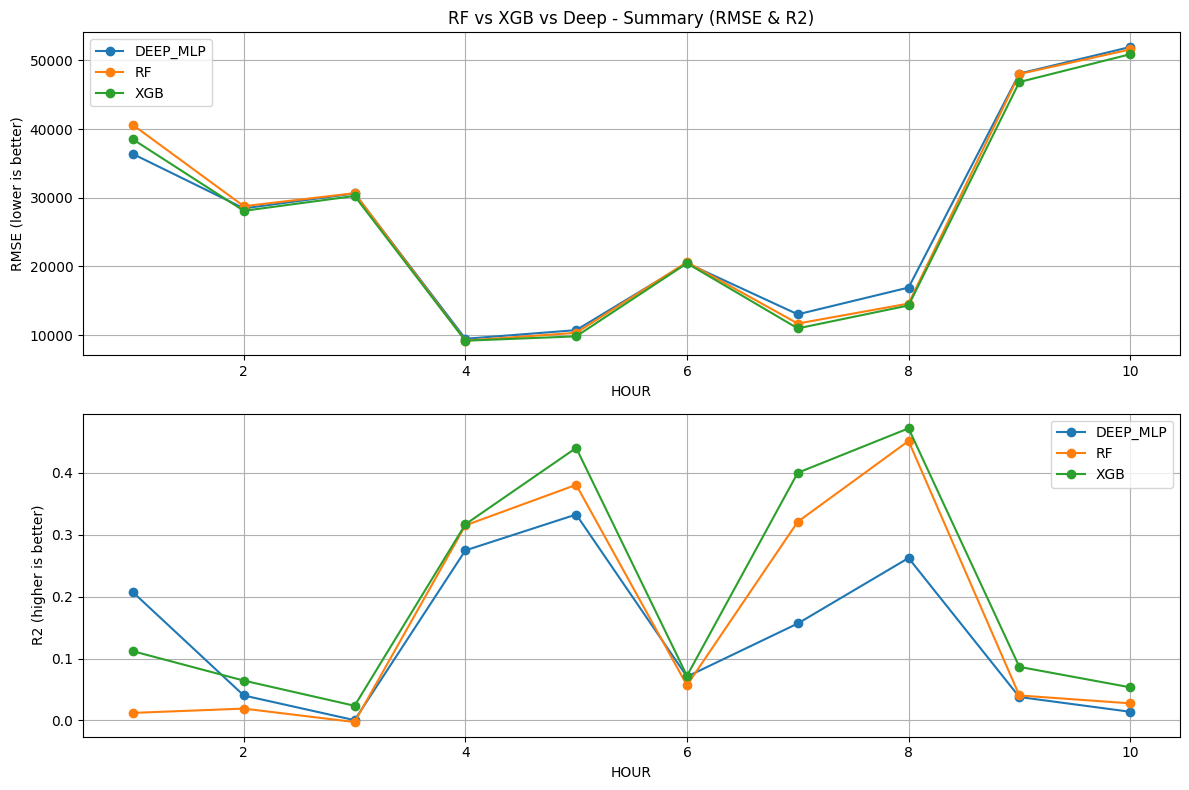

[SAVED] ./models/plots\summary_rmse_r2_onepage.png


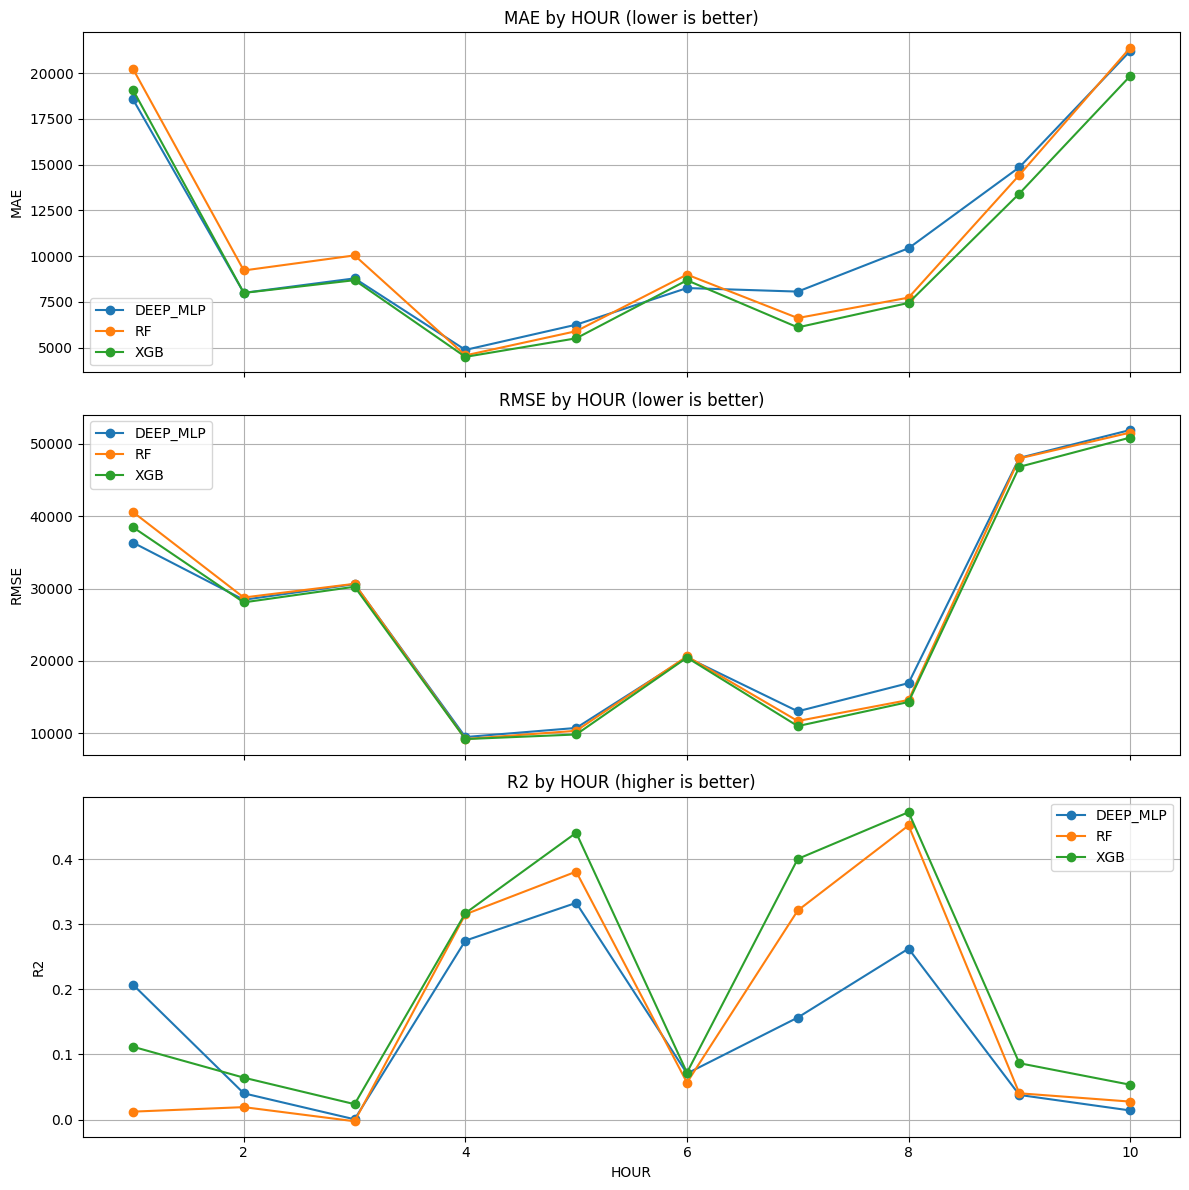

[SAVED] ./models/plots\subplot_mae_rmse_r2.png
[SAVED] ./models/plots\metrics_pivot_table.csv


In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

RES_PATH = "./models/results_by_hour.csv"
OUT_DIR = "./models/plots"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(RES_PATH)

# 시간대 정렬 보장
df["HOUR"] = pd.to_numeric(df["HOUR"], errors="coerce").astype(int)
df = df.sort_values(["HOUR", "MODEL"]).reset_index(drop=True)

models = list(df["MODEL"].unique())

# -----------------------------
# 1) 한 장 요약 그래프 (RMSE + R2 같이)
#    - 위: RMSE(낮을수록 좋음)
#    - 아래: R2(높을수록 좋음)
# -----------------------------
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2, 1, 1)
for m in models:
    tmp = df[df["MODEL"] == m].sort_values("HOUR")
    ax1.plot(tmp["HOUR"], tmp["RMSE"], marker="o", label=m)
ax1.set_title("RF vs XGB vs Deep - Summary (RMSE & R2)")
ax1.set_xlabel("HOUR")
ax1.set_ylabel("RMSE (lower is better)")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(2, 1, 2)
for m in models:
    tmp = df[df["MODEL"] == m].sort_values("HOUR")
    ax2.plot(tmp["HOUR"], tmp["R2"], marker="o", label=m)
ax2.set_xlabel("HOUR")
ax2.set_ylabel("R2 (higher is better)")
ax2.grid(True)
ax2.legend()

fig.tight_layout()
summary_path = os.path.join(OUT_DIR, "summary_rmse_r2_onepage.png")
fig.savefig(summary_path, dpi=180)
plt.show()

print("[SAVED]", summary_path)


# -----------------------------
# 2) MAE / RMSE / R2 서브플롯 (3개 지표 한 화면)
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# (A) MAE
ax = axes[0]
for m in models:
    tmp = df[df["MODEL"] == m].sort_values("HOUR")
    ax.plot(tmp["HOUR"], tmp["MAE"], marker="o", label=m)
ax.set_title("MAE by HOUR (lower is better)")
ax.set_ylabel("MAE")
ax.grid(True)
ax.legend()

# (B) RMSE
ax = axes[1]
for m in models:
    tmp = df[df["MODEL"] == m].sort_values("HOUR")
    ax.plot(tmp["HOUR"], tmp["RMSE"], marker="o", label=m)
ax.set_title("RMSE by HOUR (lower is better)")
ax.set_ylabel("RMSE")
ax.grid(True)
ax.legend()

# (C) R2
ax = axes[2]
for m in models:
    tmp = df[df["MODEL"] == m].sort_values("HOUR")
    ax.plot(tmp["HOUR"], tmp["R2"], marker="o", label=m)
ax.set_title("R2 by HOUR (higher is better)")
ax.set_xlabel("HOUR")
ax.set_ylabel("R2")
ax.grid(True)
ax.legend()

fig.tight_layout()
subplot_path = os.path.join(OUT_DIR, "subplot_mae_rmse_r2.png")
fig.savefig(subplot_path, dpi=180)
plt.show()

print("[SAVED]", subplot_path)


# -----------------------------
# (옵션) 표도 같이 저장: 시간대별 지표 피벗
# -----------------------------
pivot = df.pivot_table(index="HOUR", columns="MODEL", values=["MAE", "RMSE", "R2"])
pivot = pivot.sort_index().round(3)
table_path = os.path.join(OUT_DIR, "metrics_pivot_table.csv")
pivot.to_csv(table_path, encoding="utf-8-sig")
print("[SAVED]", table_path)


MODEL  DEEP_MLP    RF   XGB
HOUR                       
1          20.7   1.2  11.2
2           4.0   1.9   6.4
3           0.0  -0.3   2.4
4          27.5  31.5  31.7
5          33.3  38.1  44.0
6           7.1   5.7   7.2
7          15.7  32.1  40.0
8          26.2  45.2  47.2
9           3.8   4.0   8.7
10          1.4   2.8   5.4


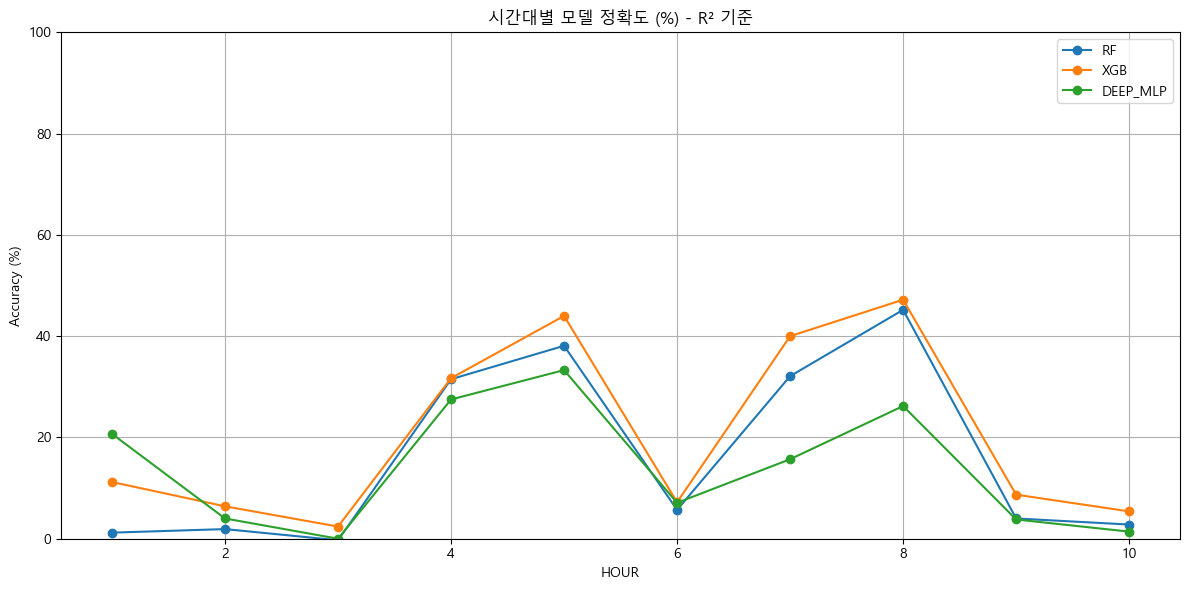

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

def set_korean_font():
    # 많이 쓰는 한글 폰트 후보 (환경에 따라 존재 여부가 다름)
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # Linux (Nanum)
        "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",                        # Windows (맑은 고딕)
        "/System/Library/Fonts/AppleGothic.ttf",              # macOS
    ]

    font_path = None
    for p in candidates:
        if os.path.exists(p):
            font_path = p
            break

    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    else:
        # 폰트 파일을 못 찾으면, 설치된 폰트 목록에서 한글 폰트가 있는지 시도
        installed = [f.name for f in fm.fontManager.ttflist]
        for name in ["NanumGothic", "NanumBarunGothic", "Malgun Gothic", "AppleGothic"]:
            if name in installed:
                plt.rcParams["font.family"] = name
                break

    # 마이너스 기호 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

df = pd.read_csv("./models/results_by_hour.csv")
df["ACC_R2_PCT"] = (df["R2"] * 100).round(1)

out_dir = "./models/plots"
os.makedirs(out_dir, exist_ok=True)

# 표
pivot = df.pivot_table(
    index="HOUR",
    columns="MODEL",
    values="ACC_R2_PCT"
)
pivot.to_csv(f"{out_dir}/accuracy_r2_percent.csv", encoding="utf-8-sig")
print(pivot)

# 그래프
plt.figure(figsize=(12,6))
for m in df["MODEL"].unique():
    tmp = df[df["MODEL"] == m]
    plt.plot(tmp["HOUR"], tmp["ACC_R2_PCT"], marker="o", label=m)

plt.title("시간대별 모델 정확도 (%) - R² 기준")
plt.xlabel("HOUR")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"{out_dir}/accuracy_r2_percent.png", dpi=180)
plt.show()


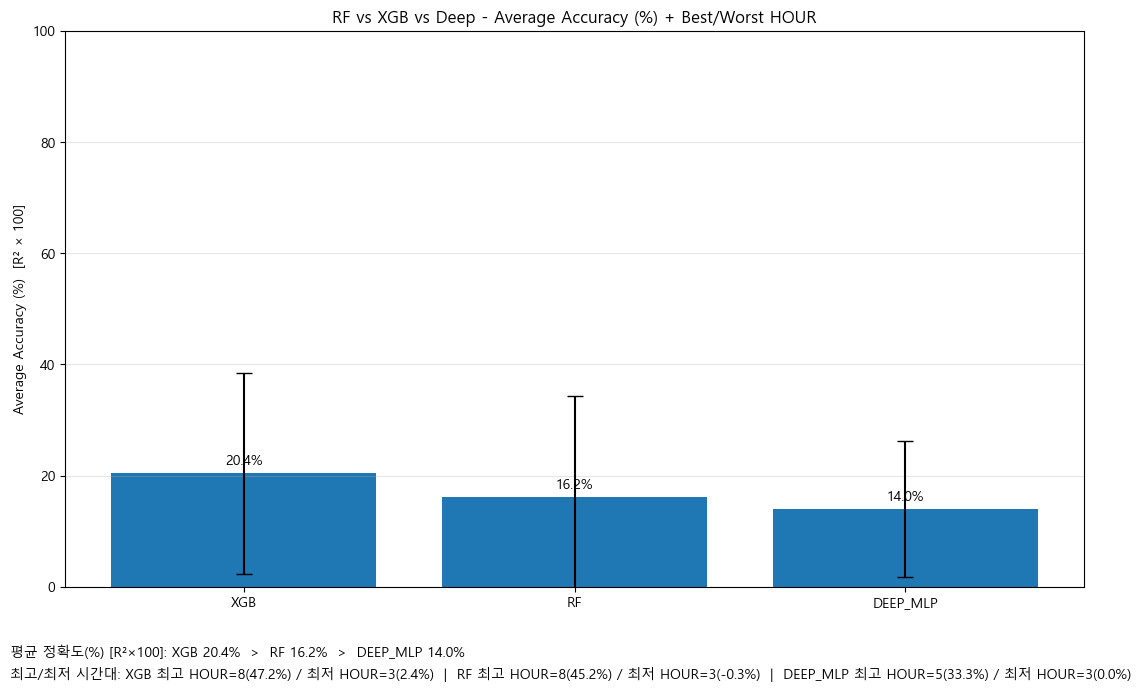

[SAVED] ./models/plots\avg_accuracy_onepage_with_best_worst.png
[SAVED] ./models/plots\avg_accuracy_by_model.csv
[SAVED] ./models/plots\avg_accuracy_with_best_worst_hour.csv


In [4]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def set_korean_font():
    # 많이 쓰는 한글 폰트 후보 (환경에 따라 존재 여부가 다름)
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # Linux (Nanum)
        "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",                        # Windows (맑은 고딕)
        "/System/Library/Fonts/AppleGothic.ttf",              # macOS
    ]

    font_path = None
    for p in candidates:
        if os.path.exists(p):
            font_path = p
            break

    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    else:
        # 폰트 파일을 못 찾으면, 설치된 폰트 목록에서 한글 폰트가 있는지 시도
        installed = [f.name for f in fm.fontManager.ttflist]
        for name in ["NanumGothic", "NanumBarunGothic", "Malgun Gothic", "AppleGothic"]:
            if name in installed:
                plt.rcParams["font.family"] = name
                break

    # 마이너스 기호 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

RES_PATH = "./models/results_by_hour.csv"
OUT_DIR = "./models/plots"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 1) Load
# -----------------------------
df = pd.read_csv(RES_PATH)

# 안전 변환
df["HOUR"] = pd.to_numeric(df["HOUR"], errors="coerce").astype(int)
df["R2"] = pd.to_numeric(df["R2"], errors="coerce")

# 정확도(%) 정의: 회귀에서 가장 흔히 쓰는 R² 기반
df["ACC_PCT"] = df["R2"] * 100

# -----------------------------
# 2) 모델별 평균/표준편차
# -----------------------------
summary = (
    df.groupby("MODEL")["ACC_PCT"]
      .agg(mean="mean", std="std", n="count")
      .reset_index()
)
summary = summary.sort_values("mean", ascending=False).reset_index(drop=True)

# CSV 저장
summary.to_csv(os.path.join(OUT_DIR, "avg_accuracy_by_model.csv"),
               index=False, encoding="utf-8-sig")

# -----------------------------
# 3) 모델별 최고/최저 시간대 찾기
# -----------------------------
best_rows = df.loc[df.groupby("MODEL")["ACC_PCT"].idxmax()].copy()
worst_rows = df.loc[df.groupby("MODEL")["ACC_PCT"].idxmin()].copy()

best_rows = best_rows[["MODEL", "HOUR", "ACC_PCT"]].rename(
    columns={"HOUR": "BEST_HOUR", "ACC_PCT": "BEST_ACC"}
)
worst_rows = worst_rows[["MODEL", "HOUR", "ACC_PCT"]].rename(
    columns={"HOUR": "WORST_HOUR", "ACC_PCT": "WORST_ACC"}
)

extrema = summary.merge(best_rows, on="MODEL", how="left").merge(worst_rows, on="MODEL", how="left")

# 저장(발표 표로도 좋음)
extrema.to_csv(os.path.join(OUT_DIR, "avg_accuracy_with_best_worst_hour.csv"),
               index=False, encoding="utf-8-sig")

# -----------------------------
# 4) 2줄 요약 텍스트 만들기
#    - 1줄: 평균 정확도 높은 순으로 나열
#    - 2줄: 각 모델 최고/최저 시간대 요약
# -----------------------------
# 1줄 요약: "XGB 93.2% > RF 91.0% > DEEP 89.4%"
parts = [f"{row.MODEL} {row.mean:.1f}%" for row in extrema.itertuples()]
line1 = "평균 정확도(%) [R²×100]: " + "  >  ".join(parts)

# 2줄 요약: "XGB 최고 HOUR=6(96.4%) / 최저 HOUR=1(88.2%) | ..."
parts2 = []
for row in extrema.itertuples():
    parts2.append(
        f"{row.MODEL} 최고 HOUR={int(row.BEST_HOUR)}({row.BEST_ACC:.1f}%) / "
        f"최저 HOUR={int(row.WORST_HOUR)}({row.WORST_ACC:.1f}%)"
    )
line2 = "최고/최저 시간대: " + "  |  ".join(parts2)

# -----------------------------
# 5) Plot: 막대 + 에러바 + 아래 2줄 요약
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 7))

x = extrema["MODEL"]
y = extrema["mean"]
yerr = extrema["std"]

bars = ax.bar(x, y, yerr=yerr, capsize=6)
ax.set_ylim(0, 100)
ax.set_ylabel("Average Accuracy (%)  [R² × 100]")
ax.set_title("RF vs XGB vs Deep - Average Accuracy (%) + Best/Worst HOUR")

# 막대 위 값 표시
for i, v in enumerate(y):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom")

ax.grid(axis="y", alpha=0.3)

# 아래 여백 확보 후 2줄 요약 넣기
plt.tight_layout(rect=[0, 0.10, 1, 1])  # 아래 공간 10% 남김
fig.text(0.01, 0.06, line1, ha="left", va="center", fontsize=10)
fig.text(0.01, 0.03, line2, ha="left", va="center", fontsize=10)

out_path = os.path.join(OUT_DIR, "avg_accuracy_onepage_with_best_worst.png")
fig.savefig(out_path, dpi=220)
plt.show()

print("[SAVED]", out_path)
print("[SAVED]", os.path.join(OUT_DIR, "avg_accuracy_by_model.csv"))
print("[SAVED]", os.path.join(OUT_DIR, "avg_accuracy_with_best_worst_hour.csv"))


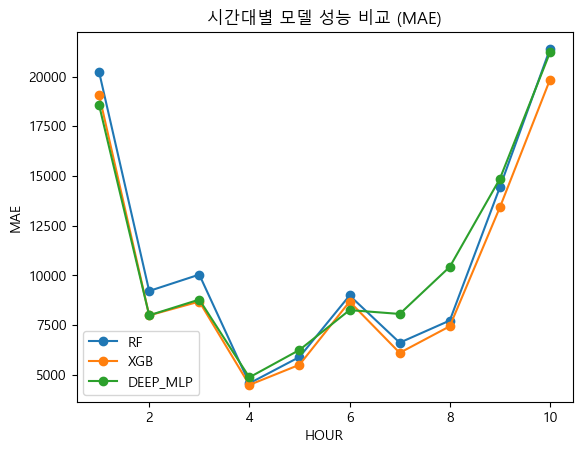

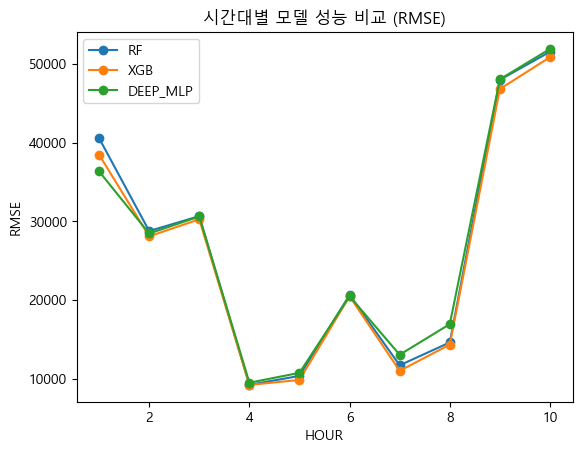

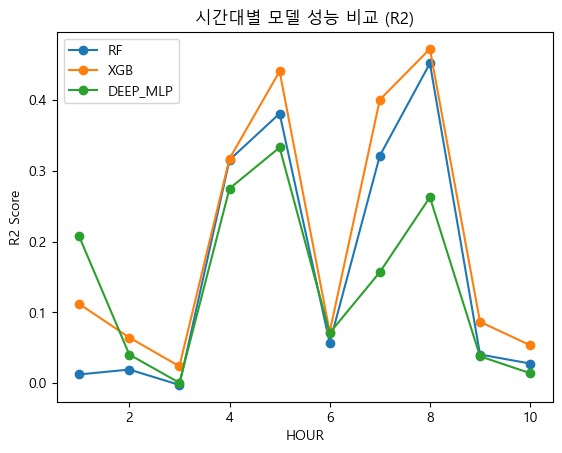

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def set_korean_font():
    # 많이 쓰는 한글 폰트 후보 (환경에 따라 존재 여부가 다름)
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # Linux (Nanum)
        "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",                        # Windows (맑은 고딕)
        "/System/Library/Fonts/AppleGothic.ttf",              # macOS
    ]

    font_path = None
    for p in candidates:
        if os.path.exists(p):
            font_path = p
            break

    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    else:
        # 폰트 파일을 못 찾으면, 설치된 폰트 목록에서 한글 폰트가 있는지 시도
        installed = [f.name for f in fm.fontManager.ttflist]
        for name in ["NanumGothic", "NanumBarunGothic", "Malgun Gothic", "AppleGothic"]:
            if name in installed:
                plt.rcParams["font.family"] = name
                break

    # 마이너스 기호 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# 결과 파일 로드
df = pd.read_csv("./models/results_by_hour.csv")

# 정렬
df["HOUR"] = df["HOUR"].astype(int)
df = df.sort_values("HOUR")

models = df["MODEL"].unique()

# =========================
# 1) MAE 비교
# =========================
plt.figure()
for m in models:
    sub = df[df["MODEL"] == m]
    plt.plot(sub["HOUR"], sub["MAE"], marker="o", label=m)

plt.xlabel("HOUR")
plt.ylabel("MAE")
plt.title("시간대별 모델 성능 비교 (MAE)")
plt.legend()
plt.show()


# =========================
# 2) RMSE 비교
# =========================
plt.figure()
for m in models:
    sub = df[df["MODEL"] == m]
    plt.plot(sub["HOUR"], sub["RMSE"], marker="o", label=m)

plt.xlabel("HOUR")
plt.ylabel("RMSE")
plt.title("시간대별 모델 성능 비교 (RMSE)")
plt.legend()
plt.show()


# =========================
# 3) R2 비교
# =========================
plt.figure()
for m in models:
    sub = df[df["MODEL"] == m]
    plt.plot(sub["HOUR"], sub["R2"], marker="o", label=m)

plt.xlabel("HOUR")
plt.ylabel("R2 Score")
plt.title("시간대별 모델 성능 비교 (R2)")
plt.legend()
plt.show()


#그래프 해석 가이드 (중요)
#MAE / RMSE ↓ 낮을수록 좋음
#R2 ↑ 높을수록 좋음
#보통 패턴: XGB > RF > Deep (데이터 적을수록)
#심야/비혼잡 시간대는 성능 급락 → 모델 분리 전략이 맞았다는 증거


In [6]:
# -*- coding: utf-8 -*-
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) 데이터 로드 & 동일 전처리용 피처 구성
#    (학습 때와 "동일하게" X 컬럼이 만들어져야 합니다)
# -----------------------------
HANSIK_PATH = "C:/data/suwon_data/수원시 한식 데이터백업.csv"
DELIV_PATH  = "C:/data/suwon_data/수원시 배달 데이터백업.csv"

hansik = pd.read_csv(HANSIK_PATH)
deliv  = pd.read_csv(DELIV_PATH)

merge_keys = ["TA_YMD", "DONG", "HOUR", "DAY"]

# 배달 피처 prefix
deliv_feat = deliv.copy()
for c in deliv_feat.columns:
    if c not in merge_keys:
        deliv_feat.rename(columns={c: f"DELIV_{c}"}, inplace=True)

df = hansik.merge(deliv_feat, on=merge_keys, how="left")

# 날짜 파생
df["TA_YMD"] = df["TA_YMD"].astype(str)
df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")
df["YEAR"] = df["DATE"].dt.year
df["MONTH"] = df["DATE"].dt.month
df["DAY_OF_MONTH"] = df["DATE"].dt.day
df["WEEKOFYEAR"] = df["DATE"].dt.isocalendar().week.astype(int)

# 타겟
USE_LOG_TARGET = False
y = df["UNIT"].copy()
if USE_LOG_TARGET:
    y = np.log1p(y)

# 피처 (학습 때와 동일하게!)
DROP_COLS = ["UNIT", "DATE", "AMT", "CNT"]  # 학습 때 제외했다면 동일하게
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")

# DATE 없는 행 제거
mask = df["DATE"].notna()
X = X.loc[mask].copy()
y = y.loc[mask].copy()
dates = df.loc[mask, "DATE"].copy()
hours = df.loc[mask, "HOUR"].astype(int).copy()

# -----------------------------
# 2) 모델 로드 경로 템플릿
# -----------------------------
MODELS_ROOT = "./models"
MODEL_PATH_TEMPLATE = os.path.join(MODELS_ROOT, "HOUR_{hour:02d}", "model_{name}.joblib")

def load_model(hour: int, name: str):
    path = MODEL_PATH_TEMPLATE.format(hour=hour, name=name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"모델 파일이 없습니다: {path}")
    return joblib.load(path)

def eval_metrics(y_true, y_pred, use_log=False):
    if use_log:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# -----------------------------
# 3) 시간대별 최적 모델 선택
#    - 날짜 기준 정렬 후 마지막 20%를 테스트로 사용 (학습과 동일)
#    - RMSE 최소 모델 선택 (동점이면 MAE, 그다음 R2)
# -----------------------------
results = []
best_models = {}

for hour in range(1, 11):
    idx = (hours == hour)
    if idx.sum() < 200:
        # 너무 적으면 스킵
        continue

    X_h = X.loc[idx].copy()
    y_h = y.loc[idx].copy()
    d_h = dates.loc[idx].copy()

    # 날짜 정렬
    order = np.argsort(d_h.values)
    X_h = X_h.iloc[order]
    y_h = y_h.iloc[order]

    # test split (마지막 20%)
    n = len(X_h)
    split = int(n * 0.8)
    X_test = X_h.iloc[split:]
    y_test = y_h.iloc[split:]

    # 두 모델 평가
    hour_scores = []
    for name in ["XGB", "DEEP_MLP"]:
        model = load_model(hour, name)
        pred = model.predict(X_test)
        mae, rmse, r2 = eval_metrics(y_test, pred, use_log=USE_LOG_TARGET)

        hour_scores.append({
            "HOUR": hour,
            "MODEL": name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

    # 최적 선택: RMSE 최소 → MAE 최소 → R2 최대
    score_df = pd.DataFrame(hour_scores)
    score_df = score_df.sort_values(["RMSE", "MAE", "R2"], ascending=[True, True, False])
    best = score_df.iloc[0].to_dict()

    best_models[hour] = best["MODEL"]
    results.extend(hour_scores)

# 결과 DataFrame
res_df = pd.DataFrame(results).sort_values(["HOUR", "MODEL"])
best_df = pd.DataFrame(
    [{"HOUR": h, "BEST_MODEL": m} for h, m in best_models.items()]
).sort_values("HOUR")

# 저장
os.makedirs(MODELS_ROOT, exist_ok=True)
res_df.to_csv(os.path.join(MODELS_ROOT, "eval_XGB_vs_DEEP_by_hour.csv"), index=False, encoding="utf-8-sig")
best_df.to_csv(os.path.join(MODELS_ROOT, "best_model_by_hour.csv"), index=False, encoding="utf-8-sig")

print("[완료] 시간대별 평가 및 최적 모델 선택")
print(best_df)


[완료] 시간대별 평가 및 최적 모델 선택
   HOUR BEST_MODEL
0     1   DEEP_MLP
1     2        XGB
2     3        XGB
3     4        XGB
4     5        XGB
5     6        XGB
6     7        XGB
7     8        XGB
8     9        XGB
9    10        XGB


In [23]:
# -*- coding: utf-8 -*-
import os
import joblib
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta

# =========================
# 설정
# =========================
import os
from dotenv import load_dotenv
load_dotenv('./../01_python/.env')
SERVICE_KEY = os.getenv('RAIN_ID')

MODELS_ROOT = "./models"
BEST_MAP_PATH = os.path.join(MODELS_ROOT, "best_model_by_hour.csv")
MODEL_PATH_TEMPLATE = os.path.join(MODELS_ROOT, "HOUR_{hour:02d}", "model_{name}.joblib")

# 학습 때 로그타겟이면 True
USE_LOG_TARGET = False

# (학습 때와 동일해야 함) 안전장치로 drop
DROP_COLS = ["UNIT", "DATE", "AMT", "CNT"]

# =========================
# 항목요약 시간대(01~10)
# =========================
HOUR_BINS = {
    1: list(range(0, 7)),     # 00~06
    2: [7, 8],
    3: [9, 10],
    4: [11, 12],
    5: [13, 14],
    6: [15, 16],
    7: [17, 18],
    8: [19, 20],
    9: [21, 22],
    10: [23],
}

# =========================
# 날짜 파생 + DAY(01=월..07=일)
# =========================
def compute_day_code(date_yyyymmdd: str) -> int:
    dt = pd.to_datetime(str(date_yyyymmdd), format="%Y%m%d", errors="raise")
    return int(dt.weekday() + 1)

def make_date_features(date_yyyymmdd: str) -> dict:
    dt = pd.to_datetime(str(date_yyyymmdd), format="%Y%m%d", errors="raise")
    return {
        "TA_YMD": str(date_yyyymmdd),
        "YEAR": int(dt.year),
        "MONTH": int(dt.month),
        "DAY_OF_MONTH": int(dt.day),
        "WEEKOFYEAR": int(dt.isocalendar().week),
    }

# =========================
# 기상청 단기예보 TMP/PCP
# =========================
def _parse_pcp_to_mm(x):
    if x is None:
        return 0.0
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    if s in ("강수없음", "없음", "", "nan", "NaN"):
        return 0.0
    if "미만" in s:
        try:
            num = float(s.replace("mm", "").replace("미만", "").strip())
            return max(0.0, num * 0.5)
        except:
            return 0.0
    if "~" in s:
        try:
            a, b = s.replace("mm", "").split("~")
            return (float(a) + float(b)) / 2.0
        except:
            return 0.0
    try:
        return float(s.replace("mm", ""))
    except:
        return 0.0

def fetch_vilage_fcst_json(service_key, base_date, base_time, nx, ny, num_rows=3000):
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    params = {
        "serviceKey": service_key,
        "pageNo": 1,
        "numOfRows": num_rows,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_hourly_tmp_pcp_for_date(service_key, target_yyyymmdd, nx, ny):
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    today = datetime.now().strftime("%Y%m%d")
    yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y%m%d")

    for bd in [today, yesterday]:
        for bt in base_times:
            try:
                js = fetch_vilage_fcst_json(service_key, bd, bt, nx, ny)
                items = js["response"]["body"]["items"]["item"]
                df = pd.DataFrame(items)

                df = df[df["category"].isin(["TMP", "PCP"])]
                df = df[df["fcstDate"].astype(str) == str(target_yyyymmdd)]
                if df.empty:
                    continue

                df["fcstTime"] = df["fcstTime"].astype(str).str.zfill(4)
                piv = df.pivot_table(index="fcstTime", columns="category", values="fcstValue", aggfunc="first").reset_index()

                if "TMP" not in piv.columns:
                    continue

                piv["TMP"] = piv["TMP"].astype(float)
                piv["PCP"] = piv["PCP"].apply(_parse_pcp_to_mm) if "PCP" in piv.columns else 0.0
                piv["PCP"] = piv["PCP"].astype(float)
                piv["base_used"] = f"{bd}-{bt}"
                return piv.sort_values("fcstTime").reset_index(drop=True)
            except:
                continue

    raise RuntimeError("해당 날짜의 기상청 예보 데이터를 찾지 못했습니다.")

def aggregate_weather_to_item_slots(hourly_df: pd.DataFrame) -> dict:
    hourly_df["HOUR_OF_DAY"] = hourly_df["fcstTime"].str[:2].astype(int)

    out = {}
    for h, hours in HOUR_BINS.items():
        sub = hourly_df[hourly_df["HOUR_OF_DAY"].isin(hours)]
        out[h] = {
            "TEMP": float(sub["TMP"].mean()) if not sub.empty else np.nan,
            "RAIN": float(sub["PCP"].sum()) if not sub.empty else 0.0,
        }

    temps = [v["TEMP"] for v in out.values() if not pd.isna(v["TEMP"])]
    fill_temp = float(np.mean(temps)) if temps else 0.0
    for h in out:
        if pd.isna(out[h]["TEMP"]):
            out[h]["TEMP"] = fill_temp

    return out

# =========================
# 모델 로드 + "모델이 기대하는 컬럼" 자동 맞춤
# =========================
def load_best_model_map():
    df = pd.read_csv(BEST_MAP_PATH)
    return df.set_index("HOUR")["BEST_MODEL"].to_dict()

def load_model(hour, name):
    path = MODEL_PATH_TEMPLATE.format(hour=hour, name=name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"모델 파일이 없습니다: {path}")
    return joblib.load(path)

def get_required_feature_names(pipeline) -> list[str]:
    """
    ColumnTransformer가 기대하는 원본 feature명 추출
    (sklearn 버전에 따라 경로가 달라질 수 있어 방어적으로 접근)
    """
    pre = pipeline.named_steps.get("preprocess", None)
    if pre is None:
        # 전처리 없는 모델이면 그냥 빈 리스트 반환
        return []
    names = []
    # transformers_는 fit 후 생성
    for name, trans, cols in getattr(pre, "transformers_", []):
        if cols is None:
            continue
        if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
            names.extend(list(cols))
    # 중복 제거
    return sorted(set([str(x) for x in names]))

def align_row_to_required_columns(X_row: pd.DataFrame, required_cols: list[str]) -> pd.DataFrame:
    """
    required_cols에 없는 컬럼은 제거, 없는 컬럼은 생성.
    - 수치/범주 판단이 어려우니 기본은 NaN으로 생성
      (학습 때 imputer가 있으면 자동 처리됨)
    """
    X = X_row.copy()

    # 불필요 컬럼 제거
    for c in list(X.columns):
        if required_cols and c not in required_cols:
            X = X.drop(columns=[c])

    # 필요한데 없는 컬럼 생성
    if required_cols:
        for c in required_cols:
            if c not in X.columns:
                X[c] = np.nan

        # 컬럼 순서도 맞춤(완전 안전)
        X = X[required_cols]

    return X

# =========================
# 핵심: 날짜 1개 → 1~10시간대 예측
# - 기상청 TEMP/RAIN을 항목요약 시간대로 집계해서 넣음
# - 시간대별 최적 모델 자동 적용
# - 모델이 기대하는 컬럼 자동 보정
# =========================
def predict_date_all_hours_with_weather(date_yyyymmdd: str, nx: int, ny: int, service_key: str = SERVICE_KEY) -> pd.DataFrame:
    day_code = compute_day_code(date_yyyymmdd)

    hourly_weather = fetch_hourly_tmp_pcp_for_date(service_key, date_yyyymmdd, nx, ny)
    weather_by_hour = aggregate_weather_to_item_slots(hourly_weather)

    best_map = load_best_model_map()
    rows = []

    for hour in range(1, 11):
        if hour not in best_map:
            continue

        model_name = best_map[hour]
        pipe = load_model(hour, model_name)

        # 기본 row: 날짜/시간대/요일 + 날씨
        row = {}
        row.update(make_date_features(date_yyyymmdd))
        row.update({
            "HOUR": hour,
            "DAY": day_code,
            "TEMP": weather_by_hour[hour]["TEMP"],
            "RAIN": weather_by_hour[hour]["RAIN"],
            # 아래는 모델이 요구할 수도 있으니 "원본값" 후보로도 넣어둠(없으면 align에서 NaN 처리됨)
            "DELIV_TEMP": weather_by_hour[hour]["TEMP"],
            "DELIV_RAIN": weather_by_hour[hour]["RAIN"],
        })

        X_row = pd.DataFrame([row])
        X_row = X_row.drop(columns=[c for c in DROP_COLS if c in X_row.columns], errors="ignore")

        # 모델이 학습 때 기대하는 컬럼으로 자동 정렬/보정
        required = get_required_feature_names(pipe)
        X_row_aligned = align_row_to_required_columns(X_row, required)

        pred = float(pipe.predict(X_row_aligned)[0])
        if USE_LOG_TARGET:
            pred = float(np.expm1(pred))

        rows.append({
            "TA_YMD": str(date_yyyymmdd),
            "DAY": day_code,
            "HOUR": hour,
            "BEST_MODEL": model_name,
            "TEMP": float(row["TEMP"]),
            "RAIN": float(row["RAIN"]),
            "PRED_UNIT": int(round(pred)),
            "KMA_BASE_USED": hourly_weather.loc[0, "base_used"],
        })

    return pd.DataFrame(rows).sort_values("HOUR").reset_index(drop=True)

# =========================
# 사용 예시
# =========================
if __name__ == "__main__":
    df_pred = predict_date_all_hours_with_weather(
        date_yyyymmdd="20251229",
        nx=61,
        ny=121
    )
    print(df_pred)


     TA_YMD  DAY  HOUR BEST_MODEL   TEMP  RAIN  PRED_UNIT  KMA_BASE_USED
0  20251229    1     1   DEEP_MLP  1.375   0.0      38130  20251229-1700
1  20251229    1     2        XGB  1.375   0.0      13636  20251229-1700
2  20251229    1     3        XGB  1.375   0.0      23589  20251229-1700
3  20251229    1     4        XGB  1.375   0.0      23325  20251229-1700
4  20251229    1     5        XGB  1.375   0.0      29701  20251229-1700
5  20251229    1     6        XGB  1.375   0.0      23359  20251229-1700
6  20251229    1     7        XGB  3.000   0.0      37893  20251229-1700
7  20251229    1     8        XGB  2.000   0.0      43601  20251229-1700
8  20251229    1     9        XGB  0.500   0.0      42972  20251229-1700
9  20251229    1    10        XGB  0.000   0.0      47836  20251229-1700


In [2]:
import sklearn
sklearn.__version__

'1.2.1'

In [3]:
import numpy
numpy.__version__

'1.23.5'